<a href="https://colab.research.google.com/github/GlubokovK/DL_CholletF_open/blob/master/Sntdr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Load data

In [39]:
# 1.Create an API key in Kaggle. (My account)
# 2. download an API key
# 4. Upload your kaggle.json
from google.colab import files 
files.upload()

#5. Install the kaggle API using 
!pip install -q kaggle

# Move the kaggle.json file into ~/.kaggle, 
# which is where the API client expects your token to be located:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



Saving kaggle.json to kaggle.json


In [40]:
! kaggle competitions download -c santander-customer-transaction-prediction

 91% 111M/122M [00:00<00:00, 93.3MB/s] 
100% 122M/122M [00:01<00:00, 126MB/s] 
  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 90.0MB/s]
 90% 110M/122M [00:00<00:00, 125MB/s] 
100% 122M/122M [00:00<00:00, 147MB/s]


In [42]:
import os
os.listdir('/content')

['.config',
 'kaggle.json',
 'test.csv.zip',
 'sample_submission.csv.zip',
 'train.csv.zip',
 'sample_data']

In [43]:
import zipfile

base_dir ='/content/Santander/'

local_zip = '/content/train.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(base_dir)
zip_ref.close()

local_zip = '/content/test.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(base_dir)
zip_ref.close()

print(os.listdir(base_dir))

['train.csv', 'test.csv']


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

base_train_df = pd.read_csv(base_dir + "train.csv")
test_df = pd.read_csv(base_dir + "test.csv")

#### Предобработка данных

In [45]:
print('train_df.shape = {}'.format(base_train_df.shape))
print('test_df.shape = {}'.format(test_df.shape))

train_df.shape = (200000, 202)
test_df.shape = (200000, 201)


In [46]:
#Сформируем отложенную выборку
base_train_df=base_train_df.sample(frac=1)
train_df_train=base_train_df.iloc[:180000]
train_df_test=base_train_df.iloc[180000:]
print(train_df_train.shape)
print(train_df_test.shape)

(180000, 202)
(20000, 202)


In [47]:
#дополнение выборки до сбалансированной, 
if 0:
    train_df_target = train_df_train
    for i in range(7):
        train_df_target=pd.concat([train_df_target,train_df_train[train_df_train['target']==1]])
    train_df_target = train_df_target.sample(frac=1)
    print(train_df_target.shape)
    
# или использование читерской выборки, без отложенной части
if 0:
    train_df_target = pd.concat([train_df_train,test2_df_all])
    train_df_target = train_df_target.sample(frac=1)
    print(train_df_target.shape)

# или стандартный тренировочный набор
if 1:
    train_df_target = train_df_train
    print(train_df_target.shape)

(180000, 202)


In [48]:
# распределение объектов по классам
n1=train_df_target[train_df_target['target']==1].shape[0]
n0=train_df_target[train_df_target['target']==0].shape[0]
n=train_df_target.shape[0]
print(train_df_target[train_df_target['target']==1].shape)
print(train_df_target[train_df_target['target']==0].shape)
print('target = 1:',n1/n)
print('target = 0:',n0/n)

(18061, 202)
(161939, 202)
target = 1: 0.1003388888888889
target = 0: 0.8996611111111111


In [0]:
x_test = test_df[test_df.columns[1:]].values
id_test = test_df[test_df.columns[0:]].values

x_train = train_df_target[train_df_target.columns[2:]].values
y_train = train_df_target[train_df_target.columns[1]].values
x_val = train_df_test[train_df_test.columns[2:]].values
y_val = train_df_test[train_df_test.columns[1]].values

In [50]:
# нормализация
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

x_val -= mean
x_val /= std

x_test = test_df[test_df.columns[1:]].values
id_test = test_df[test_df.columns[0]].values
x_test -= mean
x_test /= std

print(x_train.shape)
print(x_val.shape)

(180000, 200)
(20000, 200)


#### Построение модели: использование функционального API

In [0]:
# использование функционального API
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from sklearn.metrics import auc
from keras import regularizers
import tensorflow as tf
from keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier
#keras.wrappers.scikit_learn.KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras import layers
from keras import Input

n = 256
in_data = Input(shape=(200,), dtype='float32')

x = layers.Dense(n,
                 activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(in_data)
x = layers.BatchNormalization()(x)

y = layers.Dense(n,
                 activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
y = layers.BatchNormalization()(y)

#y = layers.add([y, x])

y = layers.Dropout(0.5)(y)
ans = layers.Dense(1, activation='sigmoid')(y)

model = Model(in_data,ans) 

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # auc

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               51456     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total para

#### подключение TensorBoard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-03-06 14:44:58--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.2.175.150, 52.86.186.182, 52.3.53.115, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.2.175.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14809752 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  14.12M  16.0MB/s    in 0.9s    

2019-03-06 14:44:59 (16.0 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [14809752/14809752]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [0]:
LOG_DIR = './my_log_dir'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://57736bd4.ngrok.io


#### обучение и оценка

In [0]:
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size=512
callbacks_list = [
    
    keras.callbacks.EarlyStopping(monitor='val_acc', # Слежение за изменением точности модели на проверочных данных
                                  patience=10, # Прерывание обучения, когда точность не улучшается дольше чем в течение одной эпохи
                                  # (другими словами, в течение двух эпох)
                                 ), # Прерывание обучения, когда качество модели перестает улучшаться
    
    keras.callbacks.ModelCheckpoint(filepath='my_model.h5', # Путь к файлу модели
                                    monitor='val_loss', # Эти аргументы требуют,
                                    # чтобы файл модели не затирался, если значение
                                    # val_loss не улучшилось, что позволяет сохранять
                                    # только лучшую модель
                                    save_best_only=True,
                                   ), # Сохранение текущих весов после каждой эпохи
    
    keras.callbacks.TensorBoard(log_dir=LOG_DIR,
                                histogram_freq=1, # Запись гистограммы активаций в каждой эпохе
                                write_graph=True,
                                write_grads=True,
                                batch_size=batch_size,
                                #embeddings_freq=1, # Запись векторных представлений в каждой эпохе
                                write_images=True
                               ),
]



history = model.fit(x_train, 
                    y_train,
                    epochs=50,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=callbacks_list,
                    verbose=1
                   )



In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [0]:
len(history.history['val_loss'])

18

In [0]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, auc
print('base: roc_auc_score = ',roc_auc_score(y_train, np.zeros(len(y_train))))
print('train: roc_auc_score = ',roc_auc_score(y_train, y_train_pred))
print('test: roc_auc_score = ',roc_auc_score(y_val, y_val_pred))

base: roc_auc_score =  0.5
train: roc_auc_score =  0.9033475326863087
test: roc_auc_score =  0.8569786978969937


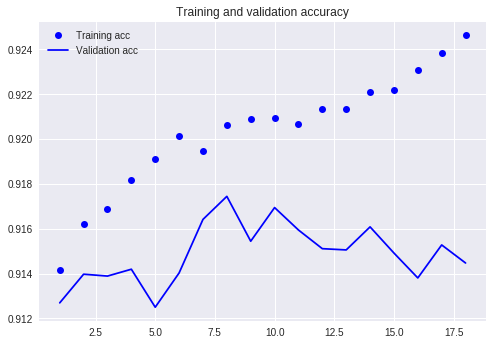

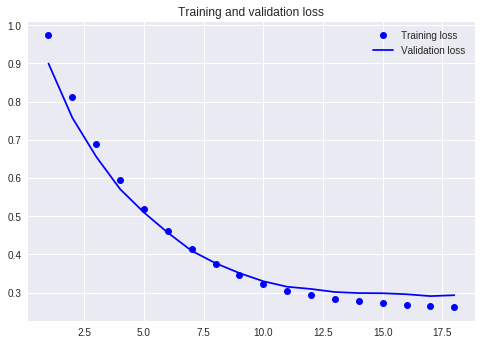

In [0]:
import matplotlib.pyplot as plt

e1=0
acc = history.history['acc'][e1:] 
val_acc = history.history['val_acc'][e1:] 
loss = history.history['loss'][e1:] 
val_loss = history.history['val_loss'][e1:] 

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Сохраняем обученную нейронную сеть

In [0]:
# https://jovianlin.io/saving-loading-keras-models/
model_json = model.to_json()
json_file = open("cifar10_model.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("cifar10_model.h5")

In [0]:
!ls

In [0]:
from google.colab import files

In [0]:
files.download("cifar10_model.json")

In [0]:
files.download("cifar10_model.h5")

In [0]:
from keras.models import model_from_json
# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')

#### подбор гиперпараметров (hyperas, не работает)

In [0]:
# x_train, y_train, x_val, y_val

def data():
  global x_train, y_train, x_val, y_val
  
  return x_train, y_train, x_val, y_val
  #a=b=c=d=1
  #return a,b,c,d


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

print(data())

In [0]:
from __future__ import print_function

In [0]:
! pip install hyperas

In [0]:
from hyperas import optim
from hyperas.distributions import choice, uniform
from __future__ import print_function
from hyperopt import Trials, STATUS_OK, tpe


def create_model(x_train, y_train, x_test, y_test):
  
  n = 64
  
  in_data = Input(shape=(200,), dtype='float32')
  
  x = layers.Dense(256, 
                   kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(in_data)
  x = layers.Activation('relu')(x)
  x = layers.BatchNormalization()(x)

  y = layers.Dense({{choice([64, 128, 256])}}, # ===================================
                   kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
  y = layers.Activation({{choice(['relu', 'sigmoid'])}})(y) # =================================
  y = layers.BatchNormalization()(y)
  
  if {{choice(['two', 'three'])}} == 'three':
    y = layers.Dense(n, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
    y = layers.Activation('relu')(y)
    y = layers.BatchNormalization()(y)


 

  y = layers.add([y, x])
  y = layers.Dropout({{uniform(0, 1)}})(y) # =================================
  ans = layers.Dense(1, activation='sigmoid')(y)
  
  
  #--------------------------------
  '''
   model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if {{choice(['three', 'four'])}} == 'four':
        model.add(Dense(100))

        # We can also choose between complete sets of layers

        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))
  '''
  #------------------------------------------------------
  
  

  model = Model(in_data,ans) 

  model.compile(optimizer={{choice(['rmsprop', 'adam', 'sgd'])}}, #============================
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # auc

  #model.summary()
  
  result = model.fit(x_train, 
                    y_train,
                    epochs=2,
                    batch_size={{choice([128, 256])}},
                    validation_split=0.2,
                    verbose=2
                   )
  
  validation_acc = np.amax(result.history['val_acc']) 
  print('Best validation acc of epoch:', validation_acc)
  return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}
  
  
  

In [0]:

best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='Santander'
                                     )
  
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

#### подбор гиперпараметров (самостоятельное решение)

#### итоговое предсказание

In [0]:
predictions = model.predict(x_test)

In [0]:
sub_df = pd.DataFrame({"ID_code":id_test})
sub_df["target"] = predictions
sub_df.to_csv(base_dir+'submission.csv', index=False)
from IPython.display import FileLink
FileLink('submission.csv')

### Опыты

#### кластеризация

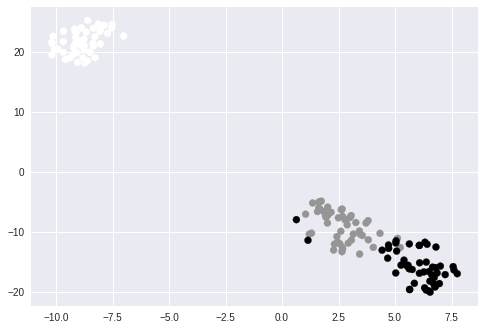

In [1]:
# Импорт библиотек
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
 
# Загрузка датасета
iris_df = datasets.load_iris()
 
# Определяем модель и скорость обучения
model = TSNE(learning_rate=100)
 
# Обучаем модель
transformed = model.fit_transform(iris_df.data)
 
# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
 
plt.scatter(x_axis, y_axis, c=iris_df.target)
plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 3.444742
[t-SNE] Computed conditional probabilities in 0.030s
[t-SNE] Iteration 50: error = 77.0209274, gradient norm = 0.4343849 (50 iterations in 0.206s)
[t-SNE] Iteration 100: error = 78.5618286, gradient norm = 0.4288956 (50 iterations in 0.211s)
[t-SNE] Iteration 150: error = 79.0088425, gradient norm = 0.3989775 (50 iterations in 0.207s)
[t-SNE] Iteration 200: error = 78.1491928, gradient norm = 0.4230899 (50 iterations in 0.212s)
[t-SNE] Iteration 250: error = 75.9683685, gradient norm = 0.4642868 (50 iterations in 0.226s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.968369
[t-SNE] Iteration 300: error = 2.3777733, gradient norm = 0.0045719 (50 iterations in 0.197s)
[t-SNE] Iteration 350: error = 2.2628200, gradient norm = 0.0018518 (

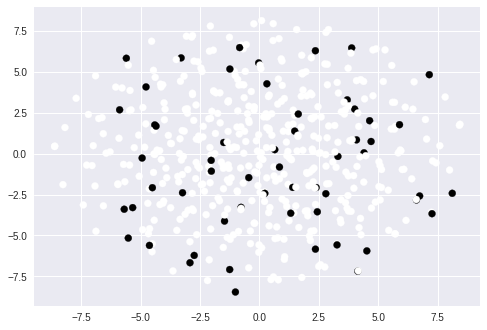

In [17]:
# Импорт библиотек
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
 

n = 500
# Определяем модель и скорость обучения
model = TSNE(learning_rate=100, verbose=2)
 
# Обучаем модель
transformed = model.fit_transform(x_train[:n])
 
# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
 
plt.scatter(x_axis, y_axis, c=y_train[:n])
plt.show()

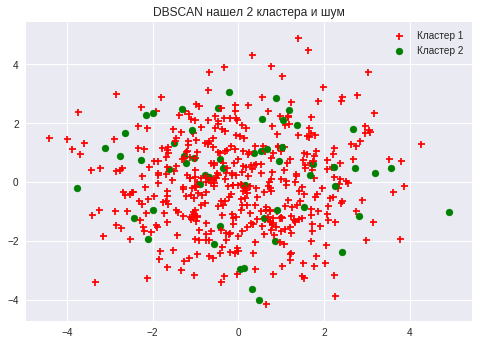

In [18]:
# Импортируем библиотеки
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
 
n=500
  
  
# Определяем модель
dbscan = DBSCAN()
 
# Обучаем
dbscan.fit(x_train[:n])
 
# Уменьшаем размерность при помощи метода главных компонент
pca = PCA(n_components=2).fit(x_train[:n])
pca_2d = pca.transform(x_train[:n])
 
# Строим в соответствии с тремя классами
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif y_train[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')

plt.legend([c1, c2], ['Кластер 1', 'Кластер 2'])
plt.title('DBSCAN нашел 2 кластера и шум')
plt.show()

#### калстеризация сетью

In [27]:
# использование функционального API
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from sklearn.metrics import auc
from keras import regularizers
import tensorflow as tf
from keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier
#keras.wrappers.scikit_learn.KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras import layers
from keras import Input

n = 256
in_data = Input(shape=(200,), dtype='float32')

x = layers.Dense(n,
                 activation='relu',
                )(in_data)


y = layers.Dense(n,
                 activation='relu',
                )(x)

y = layers.Dense(2,
                 activation='relu',
                )(y)


y = layers.Dropout(0.5)(y)
ans = layers.Dense(1, activation='sigmoid')(y)


model = Model(in_data,ans) 

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # auc

model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               51456     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 117,765
Trainable params: 117,765
Non-trainable params: 0
_________________________________________________________________


In [28]:
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

batch_size=512

history = model.fit(x_train, 
                    y_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1
                   )

Train on 144000 samples, validate on 36000 samples
Epoch 1/10
144000/144000 [==============================] - 5s 35us/step - loss: 0.4167 - acc: 0.8992 - val_loss: 0.2728 - val_acc: 0.8998
Epoch 2/10
144000/144000 [==============================] - 5s 32us/step - loss: 0.3728 - acc: 0.8992 - val_loss: 0.2582 - val_acc: 0.8998
Epoch 3/10
144000/144000 [==============================] - 5s 32us/step - loss: 0.3662 - acc: 0.8992 - val_loss: 0.2597 - val_acc: 0.8998
Epoch 4/10
144000/144000 [==============================] - 5s 32us/step - loss: 0.3611 - acc: 0.8992 - val_loss: 0.2544 - val_acc: 0.8998
Epoch 5/10
144000/144000 [==============================] - 5s 32us/step - loss: 0.3536 - acc: 0.8992 - val_loss: 0.2556 - val_acc: 0.8998
Epoch 6/10
144000/144000 [==============================] - 5s 32us/step - loss: 0.3477 - acc: 0.8992 - val_loss: 0.2581 - val_acc: 0.8998
Epoch 7/10
144000/144000 [==============================] - 5s 31us/step - loss: 0.3426 - acc: 0.8992 - val_loss: 0

In [17]:
model.layers

In [29]:
in_data = Input(shape=(200,), dtype='float32')

x = model.layers[1](in_data)


y = model.layers[2](x)

ans = model.layers[3](y)


model2 = Model(in_data,ans) 

#model2.compile(optimizer=optimizers.RMSprop(lr=1e-4),
#                  loss='mse',
#                  metrics=['mse']) # auc

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               51456     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 117,762
Trainable params: 117,762
Non-trainable params: 0
_________________________________________________________________


In [0]:
predictions = model2.predict(x_train)

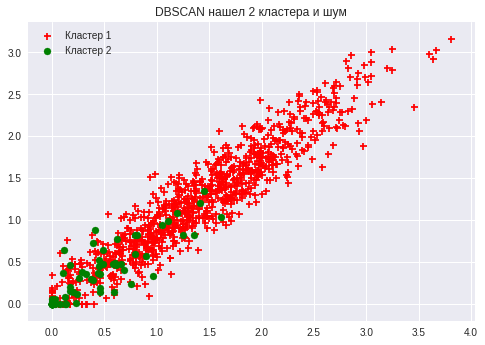

In [31]:
# Строим в соответствии с тремя классами
n=1000
predictions = model2.predict(x_train[:n])

for i in range(0, predictions.shape[0]):
    if y_train[i] == 0:
        c1 = plt.scatter(predictions[i, 0], predictions[i, 1], c='r', marker='+')
        
for i in range(0, predictions.shape[0]):
    if y_train[i] == 1:
        c2 = plt.scatter(predictions[i, 0], predictions[i, 1], c='g', marker='o')

plt.legend([c1, c2], ['Кластер 1', 'Кластер 2'])
plt.title('DBSCAN нашел 2 кластера и шум')
plt.show()

#### подбор параметров по сетке

In [0]:
# использование функционального API
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from sklearn.metrics import auc
from keras import regularizers
import tensorflow as tf
from keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier
#keras.wrappers.scikit_learn.KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Model
from keras import layers
from keras import Input



def model_create(N_layer=[64,64,32],
                 f_act='relu',                         # ['relu']
                 f_act_first=True,                     # [True, False]
                 drop_o=0.5,                           # [None, 0.3, 0.4, 0.5]
                 batch_norm=True,                      # [True, False]
                 
                 kernel_initializer='he_uniform',      # ['he_uniform', he_normal]
                 bias_initialize='zeros',              #
                     
                 kernel_regularizer=None,              # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                 bias_regularizer=None,                # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                 activity_regularizer=None,            # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                     
                 kernel_constraint=None,               #
                 bias_constraint=None,                 #
                 optim = 'adam',                       # ['adam','RMSprop','Adadelta']
                ):
  

    in_data = Input(shape=(200,), dtype='float32')
  
    y = layers.Dense(N_layer[0], 
                     
                     kernel_initializer=kernel_initializer,
                     #bias_initialize=bias_initialize,
                     
                     kernel_regularizer=kernel_regularizer,
                     bias_regularizer=bias_regularizer,
                     activity_regularizer=activity_regularizer,
                     
                     kernel_constraint=kernel_constraint,
                     bias_constraint=bias_constraint,
                     
                    )(in_data)
    y = layers.Activation(f_act)(y)
  
  #-----------------------------------------------------------------
    for i in range(1,len(N_layer)):
        y = layers.Dense(N_layer[i],
                         
                        )(y)
    if f_act_first:
        y = layers.Activation(f_act)(y)
        if batch_norm:
            y = layers.BatchNormalization()(y)
      
    else:
        if batch_norm:
            y = layers.BatchNormalization()(y)
        y = layers.Activation(f_act)(y)
      
    if drop_o:
        y = layers.Dropout(drop_o)(y)

      
    
    
  #-----------------------------------------------------------------
    ans = layers.Dense(1, activation='sigmoid')(y)
    
    model = Model(in_data,ans) 
  
    model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy']) # auc
  
    return model

def fit_model(model,
              x_train,
              y_train,
              batch_s=256, # [64,128,256,512]
              epochs=50,
             ):
    
    callbacks_list = [
    
    keras.callbacks.EarlyStopping(monitor='val_acc', # Слежение за изменением точности модели на проверочных данных
                                  patience=4, # Прерывание обучения, когда точность не улучшается дольше чем в течение одной эпохи
                                  # (другими словами, в течение двух эпох)
                                 ), # Прерывание обучения, когда качество модели перестает улучшаться
    
    keras.callbacks.ModelCheckpoint(filepath='my_model.h5', # Путь к файлу модели
                                    monitor='val_loss', # Эти аргументы требуют,
                                    # чтобы файл модели не затирался, если значение
                                    # val_loss не улучшилось, что позволяет сохранять
                                    # только лучшую модель
                                    save_best_only=True,
                                   ), # Сохранение текущих весов после каждой эпохи
    
    #keras.callbacks.TensorBoard(log_dir=LOG_DIR,
    #                            histogram_freq=1, # Запись гистограммы активаций в каждой эпохе
    #                            write_graph=True,
    #                            write_grads=True,
    #                            batch_size=batch_size,
    #                            #embeddings_freq=1, # Запись векторных представлений в каждой эпохе
    #                            write_images=True
    #                           ),
    ]
    
    history = model.fit(x_train, 
                    y_train,
                    epochs=epochs,
                    batch_size=batch_s,
                    validation_split=0.2,
                    callbacks=callbacks_list,
                    verbose=1
                   )
    
    return history
    

In [63]:
model=model_create(N_layer=[64,64,32],
                 f_act='relu',                         # ['relu']
                 f_act_first=True,                     # [True, False]
                 drop_o=0.5,                           # [None, 0.3, 0.4, 0.5]
                 batch_norm=True,                      # [True, False]
                 
                 kernel_initializer='he_uniform',      # ['he_uniform', he_normal]
                     
                 kernel_regularizer=None,              # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                 bias_regularizer=None,                # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                 activity_regularizer=None,            # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                     
                 optim = 'adam',                       # ['adam','RMSprop','Adadelta']
                )

history=fit_model(model,
              x_train,
              y_train,
              batch_s=256, # [64,128,256,512]
              epochs=10
             )

Train on 144000 samples, validate on 36000 samples
Epoch 1/10
144000/144000 [==============================] - 5s 34us/step - loss: 0.8291 - acc: 0.5629 - val_loss: 0.6037 - val_acc: 0.6911
Epoch 2/10
144000/144000 [==============================] - 4s 25us/step - loss: 0.6123 - acc: 0.6817 - val_loss: 0.4686 - val_acc: 0.8507
Epoch 3/10
144000/144000 [==============================] - 4s 26us/step - loss: 0.4831 - acc: 0.7817 - val_loss: 0.3709 - val_acc: 0.8956
Epoch 4/10
144000/144000 [==============================] - 4s 25us/step - loss: 0.3904 - acc: 0.8447 - val_loss: 0.2992 - val_acc: 0.9071
Epoch 5/10
144000/144000 [==============================] - 4s 25us/step - loss: 0.3261 - acc: 0.8784 - val_loss: 0.2578 - val_acc: 0.9109
Epoch 6/10
144000/144000 [==============================] - 4s 25us/step - loss: 0.2899 - acc: 0.8940 - val_loss: 0.2440 - val_acc: 0.9121
Epoch 7/10
144000/144000 [==============================] - 4s 25us/step - loss: 0.2693 - acc: 0.9023 - val_loss: 0

In [0]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)

In [83]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, auc
print('base: roc_auc_score = ',roc_auc_score(y_train, np.zeros(len(y_train))))
print('train: roc_auc_score = ',roc_auc_score(y_train, y_train_pred))
print('test: roc_auc_score = ',roc_auc_score(y_val, y_val_pred))

base: roc_auc_score =  0.5
train: roc_auc_score =  0.8710870116612954
test: roc_auc_score =  0.8585420951062582


In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, auc
history.history

param_dict={
    'N_layer':[[32,32]],
    
    'f_act': ['relu'],
    'f_act_first': [True, False],
    'drop_o': [None, 0.3, 0.4, 0.5],
    'batch_norm': [True, False],
    
    'kernel_initializer': ['he_uniform', 'he_normal'],
                     
    'kernel_regularizer': [None, [0.001, 0.001], [0.0001, 0.0001]],
    'bias_regularizer': [None, [0.001, 0.001], [0.0001, 0.0001]],
    'activity_regularizer': [None, [0.001, 0.001], [0.0001, 0.0001]],
                     
    'optim': ['adam','RMSprop','Adadelta'],
    
    'batch_s': [64, 128, 256, 512],
    'epochs': 2
    
}

In [102]:

report_list=[]

k = 4
num_val_samples = len(x_train) // k



for N_layer in param_dict['N_layer']:
    
    kernel_initializer= param_dict['kernel_initializer'][0]
    drop_o = param_dict['drop_o'][0]
    optim = param_dict['optim'][0]
    batch_s = param_dict['batch_s'][0]
    

    #------------------------------------------------------------------------
    # фиксированные параметры
    kernel_regularizer = param_dict['kernel_regularizer'][0]
    bias_regularizer = param_dict['bias_regularizer'][0]
    activity_regularizer = param_dict['activity_regularizer'][0]
    
    batch_norm = param_dict['batch_norm'][0]
    f_act_first = param_dict['f_act_first'][0]
    f_act = param_dict['f_act'][0]
    epochs = param_dict['epochs']
    #-----------------------------------------------------------------------
    
    
    all_scores = []
    hist_list = []
    roc_auc_scr_list =[]
    for i in range(k):    
        print('processing fold #', i)

        val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples] 
        val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
        partial_train_data = np.concatenate([x_train[:i * num_val_samples], x_train[(i + 1) * num_val_samples:]], axis=0) 
        partial_train_targets = np.concatenate([y_train[:i * num_val_samples], y_train[(i + 1) * num_val_samples:]], axis=0) 


        model=model_create(N_layer = N_layer,
                           f_act = f_act,                                 # ['relu']
                           f_act_first = f_act_first,                     # [True, False]
                           drop_o = drop_o,                               # [None, 0.3, 0.4, 0.5]
                           batch_norm = batch_norm,                       # [True, False]
                           kernel_initializer = kernel_initializer,       # ['he_uniform', he_normal]
                           kernel_regularizer = kernel_regularizer,       # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                           bias_regularizer = bias_regularizer,           # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                           activity_regularizer = activity_regularizer,   # [None, regularizers.l1_l2(l1=0.001, l2=0.001)]
                           optim = optim,                                 # ['adam','RMSprop','Adadelta']
                    )

        history = fit_model(model,
                            x_train[:10000],
                            y_train[:10000],
                            batch_s=batch_s, # [64, 128, 256, 512]
                            epochs=epochs
                           )


        val_loss, val_acc = model.evaluate(val_data, val_targets, verbose=0)
        y_val_pred = model.predict(x_val)
        roc_auc_scr = roc_auc_score(y_val, y_val_pred)
        
        all_scores.append(val_acc) #Оценка модели по проверочным данным
        hist_list.append(len(history.history[list(history.history.keys())[0]]))
        roc_auc_scr_list.append(roc_auc_scr)
        
        mean_all_scores = np.mean(all_scores)
        mean_roc_auc_scr_list = np.mean(roc_auc_scr_list)
        
        print('all_scores = {}'.format(all_scores))
        print('all_roc_auc = {}'.format(roc_auc_scr_list))
        print('mean acc = {}'.format(mean_all_scores))
        print('mean roc_auc = {}'.format(mean_roc_auc_scr_list))
        print('---------------------------------------------------------------------')
    
    print('*********************************************************************************************************')
    print('mean epochs = ', int(np.mean(hist_list)))
    print('mean acc = {}'.format(mean_all_scores))
    print('mean roc_auc = {}'.format(mean_roc_auc_scr_list))
    print('*********************************************************************************************************')
        
        
    report={
        'N_layer': N_layer,
        'kernel_initializer': kernel_initializer,
        'drop_o': drop_o,
        'optim' : optim,
        'batch_s' : batch_s,
        'estimate' : [val_loss, val_acc],
        'y_val_pred': y_train_pred
     
        
        
        
        
    }

    
    
    
    

processing fold # 0
Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 6s 730us/step - loss: 0.8250 - acc: 0.5229 - val_loss: 0.7815 - val_acc: 0.5350
Epoch 2/2
8000/8000 [==============================] - 0s 50us/step - loss: 0.7450 - acc: 0.5586 - val_loss: 0.7180 - val_acc: 0.5695
all_scores = [0.5768]
mean acc = 0.5768
mean roc_auc = 0.5463023034503013
---------------------------------------------------------------------
processing fold # 1
Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 6s 716us/step - loss: 0.7876 - acc: 0.5078 - val_loss: 0.7748 - val_acc: 0.4945
Epoch 2/2
8000/8000 [==============================] - 0s 50us/step - loss: 0.7148 - acc: 0.5543 - val_loss: 0.7097 - val_acc: 0.5440
all_scores = [0.5768, 0.5733555555555555]
mean acc = 0.5750777777777778
mean roc_auc = 0.5225722193749542
---------------------------------------------------------------------
proces

In [100]:
history.history[list(history.history.keys())[0]]

[0.814524863243103, 0.7466410613059997]

In [34]:
model = model_create()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                12864     
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
__________